In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import sklearn
from sklearn.impute import SimpleImputer
from scipy.stats import zscore
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

In [2]:
df=pd.read_csv("loan.csv")
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


# EDA

In [3]:
df.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [5]:
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

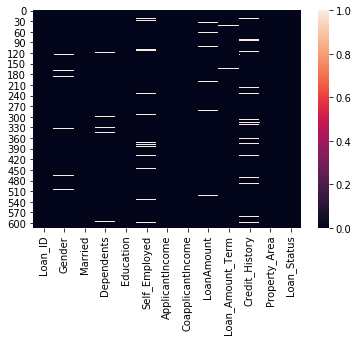

In [6]:
sns.heatmap(df.isnull())
plt.show()

In [7]:
cf=[]
nf=[] 
for fea in df.columns:
    if df[fea].dtype == 'O':
            cf.append(fea)
    else:
            nf.append(fea)
print(cf)
print('\n',nf)

['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']

 ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']


In [8]:
print('No of numerical features: ',len(nf))
print('No of categorical features: ',len(cf))

No of numerical features:  5
No of categorical features:  8


In [9]:
for col in cf:
    print(df[col].value_counts()) 

LP002239    1
LP002619    1
LP001116    1
LP002035    1
LP002652    1
           ..
LP002690    1
LP001825    1
LP001034    1
LP001664    1
LP001011    1
Name: Loan_ID, Length: 614, dtype: int64
Male      489
Female    112
Name: Gender, dtype: int64
Yes    398
No     213
Name: Married, dtype: int64
0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64
Graduate        480
Not Graduate    134
Name: Education, dtype: int64
No     500
Yes     82
Name: Self_Employed, dtype: int64
Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64
Y    422
N    192
Name: Loan_Status, dtype: int64


In [10]:
for col in nf:
    print(col,' : ',df[col].nunique()) 

ApplicantIncome  :  505
CoapplicantIncome  :  287
LoanAmount  :  203
Loan_Amount_Term  :  10
Credit_History  :  2


In [11]:
#filling missing data for categorical data
df['Gender'].fillna(df['Gender'].mode()[0], inplace = True)
df['Married'].fillna(df['Married'].mode()[0], inplace = True)
df['Dependents'].fillna(df['Dependents'].mode()[0], inplace = True)
df['Self_Employed'].fillna(df['Self_Employed'].mode()[0], inplace = True)

In [12]:
#filling missing data with imputation for numerical data
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values  = np.nan, strategy = 'mean')
df['LoanAmount']=imp.fit_transform(df['LoanAmount'].values.reshape(-1,1))
df["Loan_Amount_Term"]=imp.fit_transform(df['Loan_Amount_Term'].values.reshape(-1,1))
df["Credit_History"]=imp.fit_transform(df['Credit_History'].values.reshape(-1,1))

In [13]:
df.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [14]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y


# Statistics Summary

In [15]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,614.000000,614.000000,614.000000
mean,5403.459283,1621.245798,146.412162,342.000000,0.842199
std,6109.041673,2926.248369,84.037468,64.372489,0.349681
min,150.000000,0.000000,9.000000,12.000000,0.000000
25%,2877.500000,0.000000,100.250000,360.000000,1.000000
50%,3812.500000,1188.500000,129.000000,360.000000,1.000000
75%,5795.000000,2297.250000,164.750000,360.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.000000,1.000000


In [16]:
df.describe(include = ['O'])

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
count,614,614,614,614,614,614,614,614
unique,614,2,2,4,2,2,3,2
top,LP002239,Male,Yes,0,Graduate,No,Semiurban,Y
freq,1,502,401,360,480,532,233,422


 Coding categorical data in numeric form

In [17]:
for col_name in df.columns:
    if(df[col_name].dtype == 'object'):
        df[col_name]= df[col_name].astype('category')
        df[col_name] = df[col_name].cat.codes

In [18]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,0,1,0,0,0,0,5849,0.0,146.412162,360.0,1.0,2,1
1,1,1,1,1,0,0,4583,1508.0,128.000000,360.0,1.0,0,0
2,2,1,1,0,0,1,3000,0.0,66.000000,360.0,1.0,2,1
3,3,1,1,0,1,0,2583,2358.0,120.000000,360.0,1.0,2,1
4,4,1,0,0,0,0,6000,0.0,141.000000,360.0,1.0,2,1


# Data visualisation

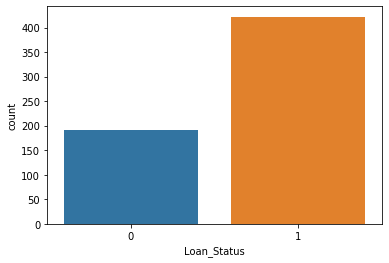

In [19]:
sns.countplot(df['Loan_Status'])
plt.show()

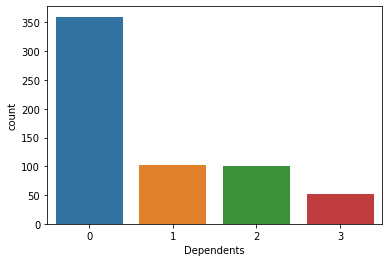

In [20]:
sns.countplot(df['Dependents'])
plt.show()

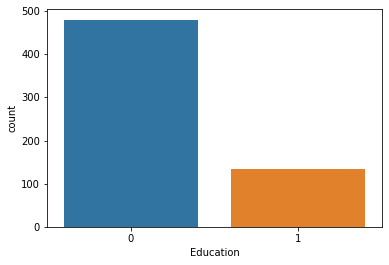

In [21]:
sns.countplot(df['Education'])
plt.show()

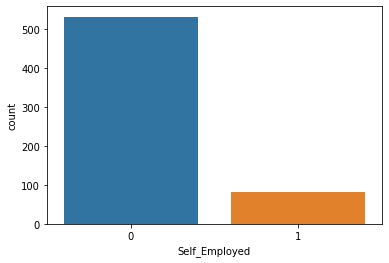

In [22]:
sns.countplot(df['Self_Employed'])
plt.show()

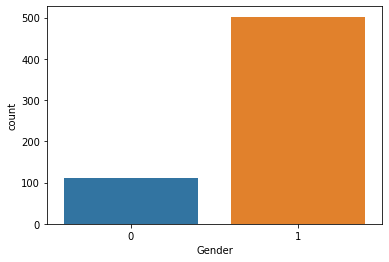

In [23]:
sns.countplot(df['Gender'])
plt.show()

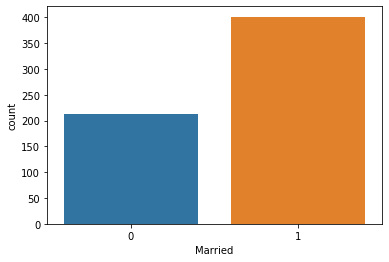

In [24]:
sns.countplot(df['Married'])
plt.show()

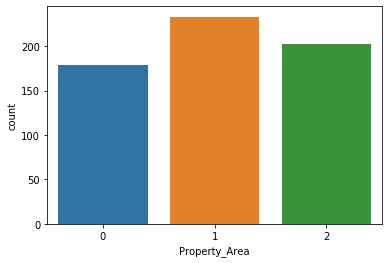

In [25]:
sns.countplot(df['Property_Area'])
plt.show()

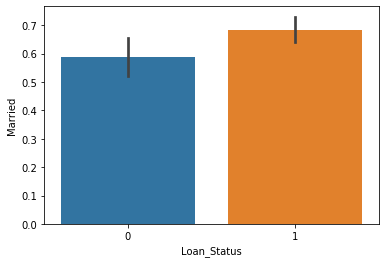

In [26]:
#bivariate analysis
sns.barplot(x='Loan_Status',y='Married',data=df) 
plt.show()

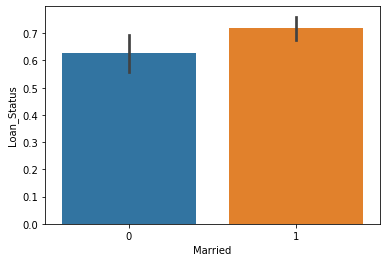

In [27]:
sns.barplot(x='Married',y='Loan_Status',data=df) 
plt.show()

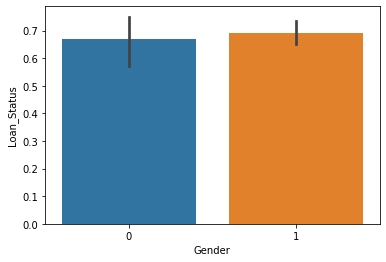

In [28]:
sns.barplot(x='Gender',y='Loan_Status',data=df) 
plt.show()

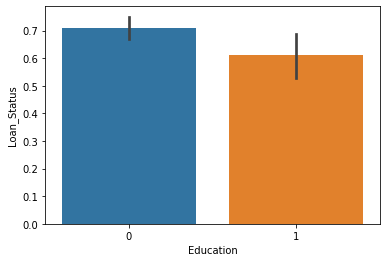

In [29]:
sns.barplot(x='Education',y='Loan_Status',data=df) 
plt.show()

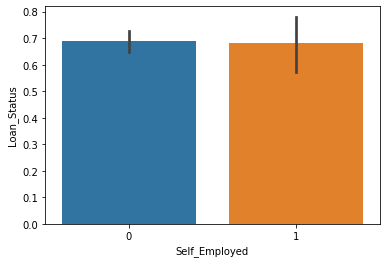

In [30]:
sns.barplot(x='Self_Employed',y='Loan_Status',data=df) 
plt.show()

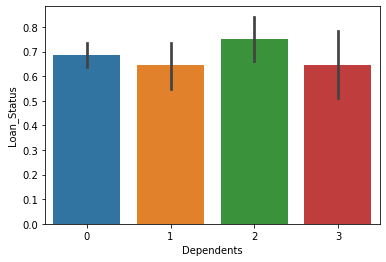

In [31]:
sns.barplot(x='Dependents',y='Loan_Status',data=df) 
plt.show()

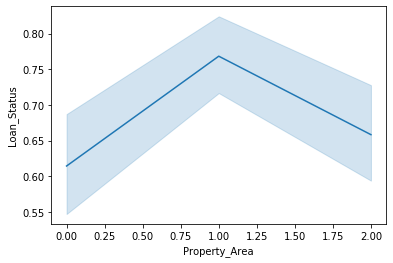

In [32]:
sns.lineplot(x='Property_Area',y='Loan_Status',data=df) 
plt.show()

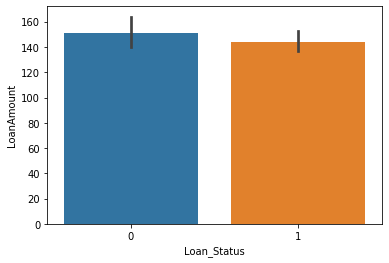

In [33]:
sns.barplot(x='Loan_Status',y='LoanAmount',data=df) 
plt.show()

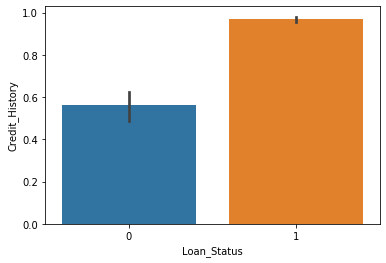

In [34]:
sns.barplot(x='Loan_Status',y='Credit_History',data=df) 
plt.show()

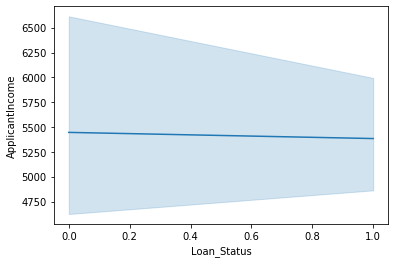

In [35]:
sns.lineplot(x='Loan_Status',y='ApplicantIncome',data=df) 
plt.show()

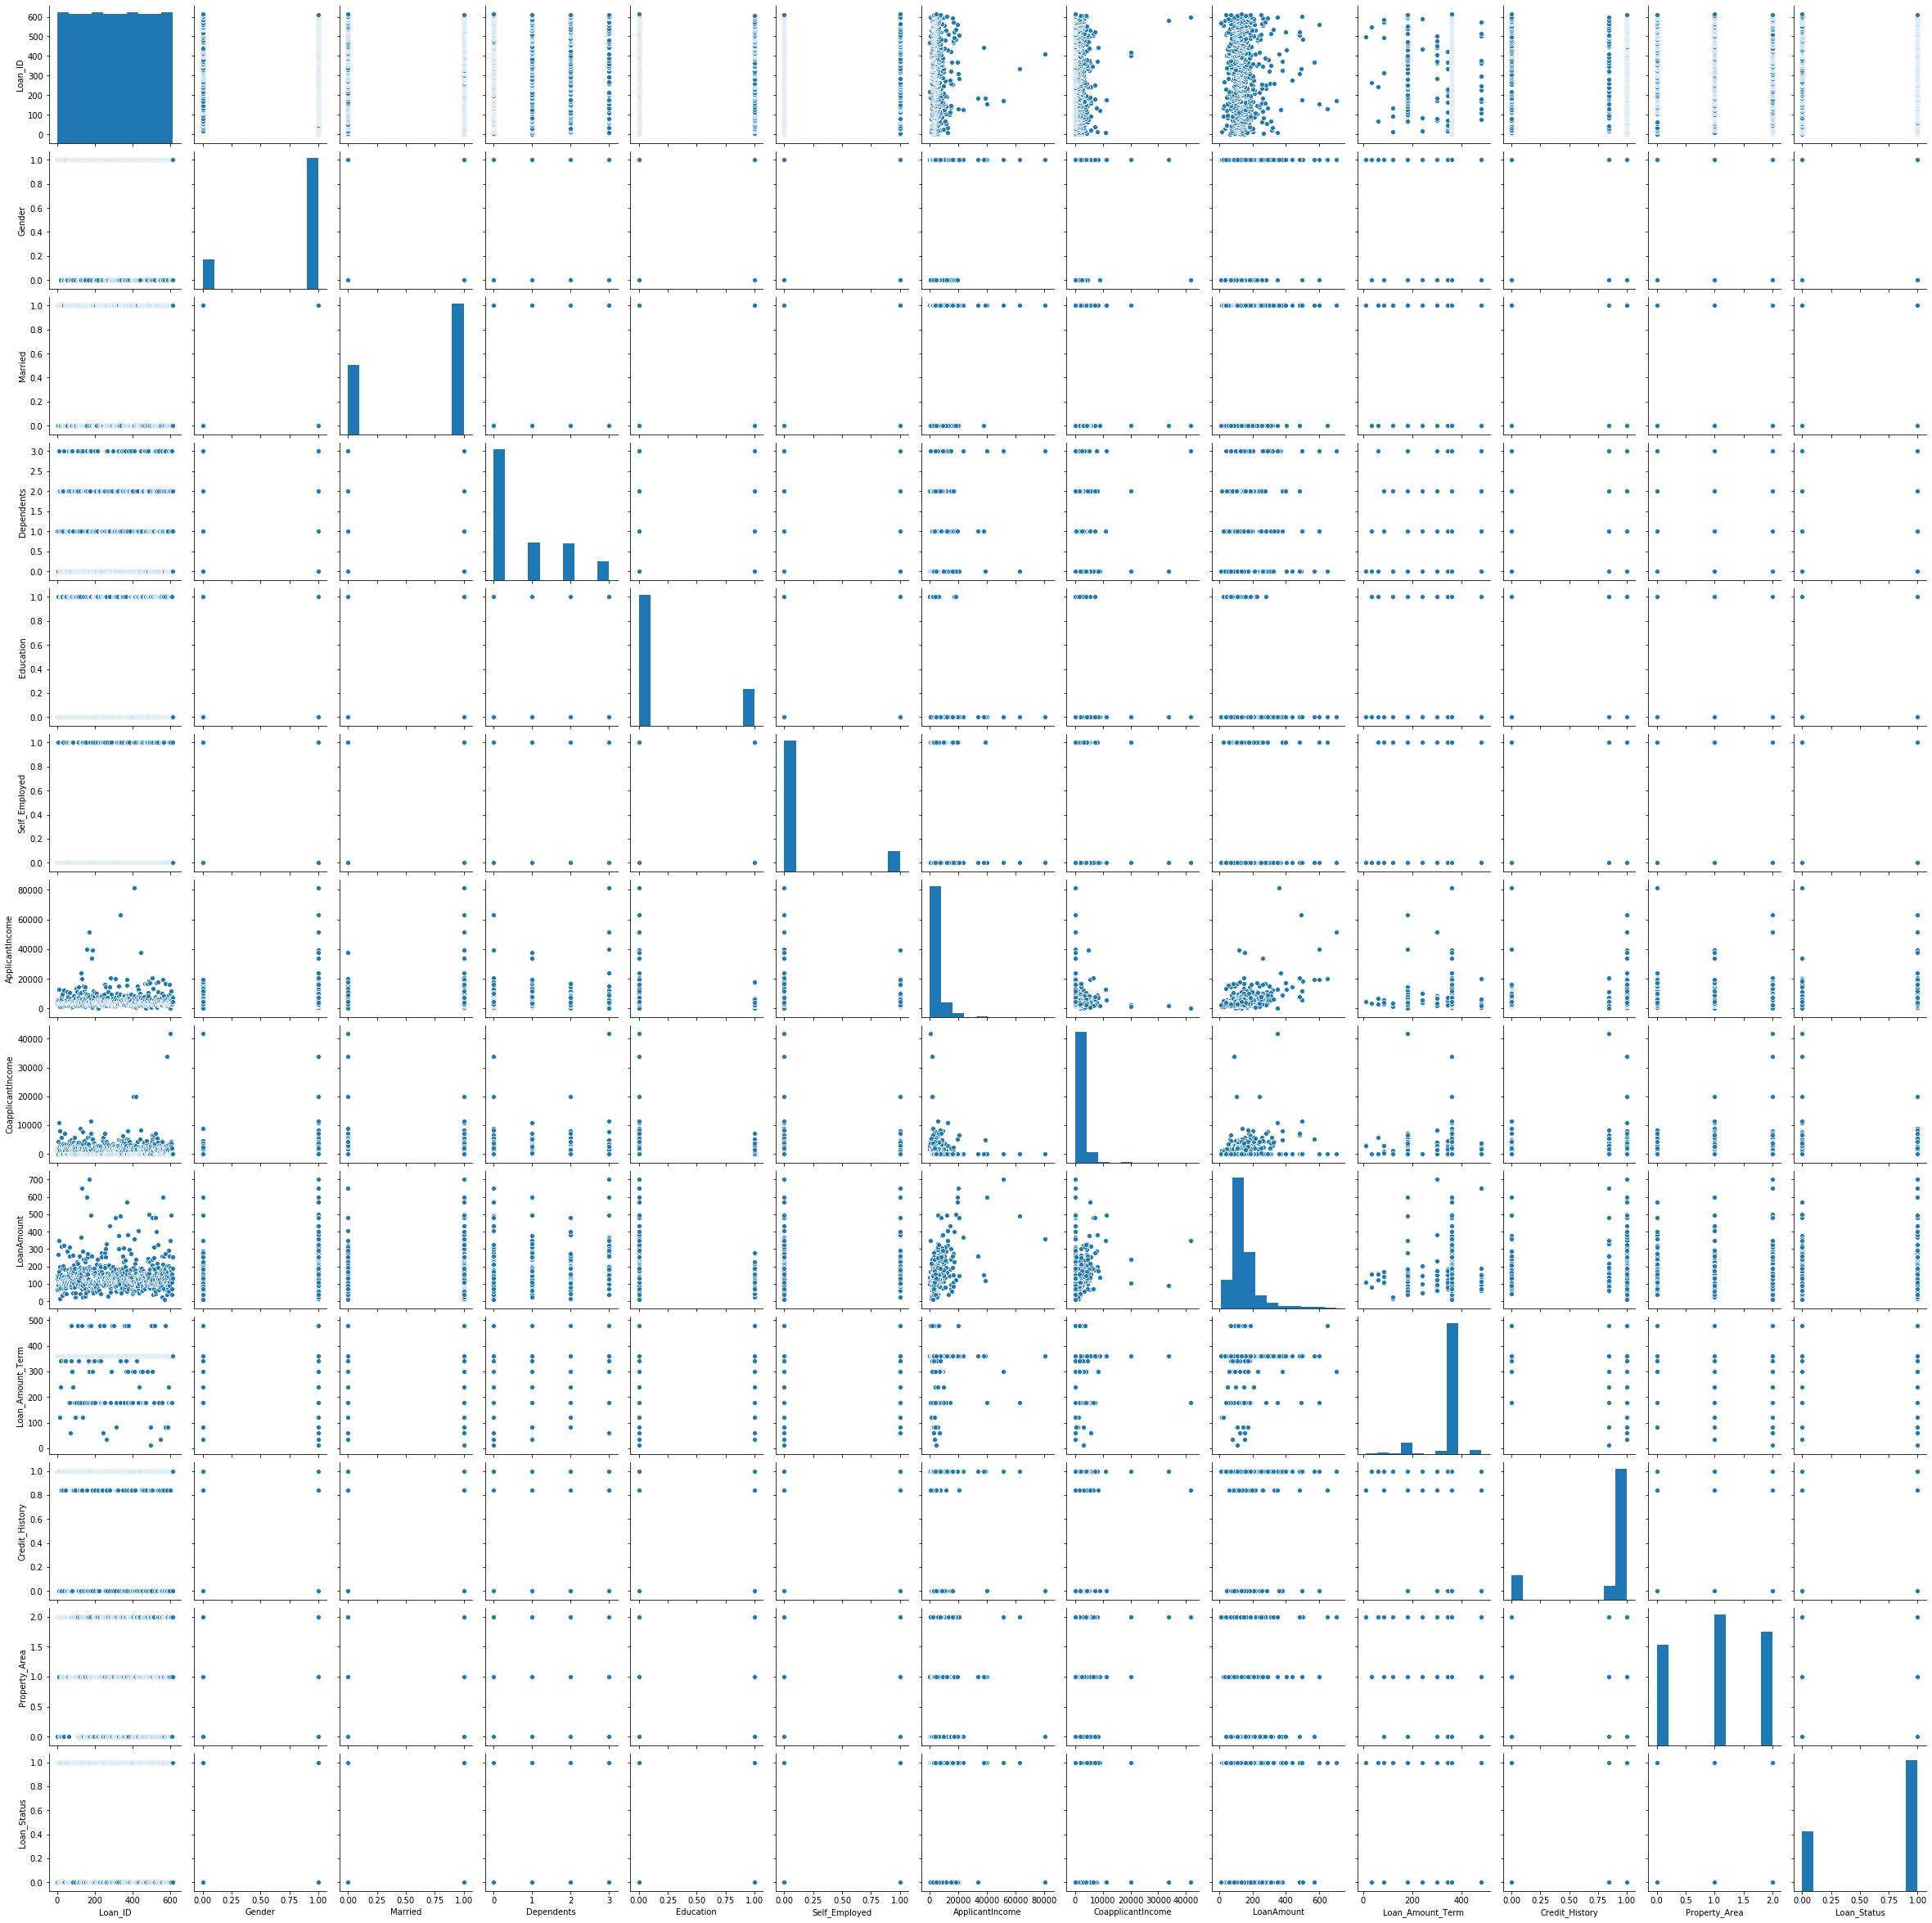

In [36]:
sns.pairplot(df)
plt.show()

In [37]:
# correlation matrix
df.corr()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,1.000000,-0.028029,-0.016013,0.051559,0.039442,0.032874,0.016925,0.039211,0.035684,-0.028945,-0.032429,-0.155416,0.011773
Gender,-0.028029,1.000000,0.364569,0.172914,0.045364,-0.000525,0.058809,0.082912,0.107930,-0.073567,0.012819,-0.025752,0.017987
Married,-0.016013,0.364569,1.000000,0.334216,0.012304,0.004489,0.051708,0.075948,0.147141,-0.100863,0.005852,0.004257,0.091478
Dependents,0.051559,0.172914,0.334216,1.000000,0.055752,0.056798,0.118202,0.030430,0.163106,-0.101054,-0.037392,-0.000244,0.010118
Education,0.039442,0.045364,0.012304,0.055752,1.000000,-0.010383,-0.140760,-0.062290,-0.166998,-0.077242,-0.077936,-0.065243,-0.085884
Self_Employed,0.032874,-0.000525,0.004489,0.056798,-0.010383,1.000000,0.127180,-0.016100,0.115260,-0.033943,-0.002260,-0.030860,-0.003700
ApplicantIncome,0.016925,0.058809,0.051708,0.118202,-0.140760,0.127180,1.000000,-0.116605,0.565620,-0.045242,-0.014477,-0.009500,-0.004710
CoapplicantIncome,0.039211,0.082912,0.075948,0.030430,-0.062290,-0.016100,-0.116605,1.000000,0.187828,-0.059675,-0.001665,0.010522,-0.059187
LoanAmount,0.035684,0.107930,0.147141,0.163106,-0.166998,0.115260,0.565620,0.187828,1.000000,0.038801,-0.007738,-0.044776,-0.036416
Loan_Amount_Term,-0.028945,-0.073567,-0.100863,-0.101054,-0.077242,-0.033943,-0.045242,-0.059675,0.038801,1.000000,0.001395,-0.077620,-0.020974


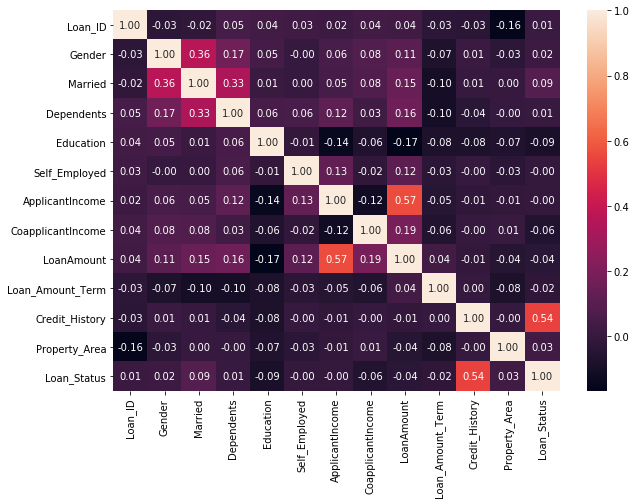

In [38]:
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(), annot=True, fmt='.2f')
plt.show()

# Data Cleaning

<Figure size 720x360 with 0 Axes>

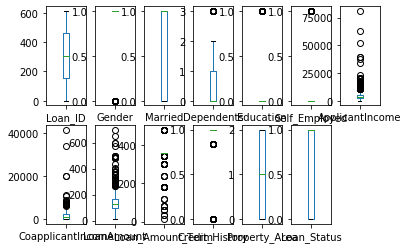

In [39]:
plt.figure(figsize=(10,5))
df.plot(kind='box',subplots=True,layout=(2,7)) 
plt.show()

In [40]:
from scipy.stats import zscore # removing outliers
z=abs(zscore(df))
print(df.shape)
df_final=df.loc[(z<3).all(axis=1)]
print(df_final.shape)
df=df_final

(614, 13)
(577, 13)


In [41]:
y=df["Loan_Status"]
dfx=df.drop(columns=['Loan_Status'], axis=1)

In [42]:
dfx.skew()

Loan_ID              0.010879
Gender              -1.622920
Married             -0.630211
Dependents           1.052106
Education            1.306588
Self_Employed        2.252848
ApplicantIncome      2.148522
CoapplicantIncome    1.350517
LoanAmount           1.113132
Loan_Amount_Term    -2.077031
Credit_History      -1.921860
Property_Area       -0.055332
dtype: float64

In [43]:
# handling skewness
from sklearn.preprocessing import PowerTransformer
pt=PowerTransformer(method='yeo-johnson')
d=pt.fit_transform(dfx)
d=pd.DataFrame(d,columns=dfx.columns)
x=d

In [44]:
x.skew()

Loan_ID             -0.284298
Gender              -1.622920
Married             -0.630211
Dependents           0.478360
Education            1.306588
Self_Employed        2.252848
ApplicantIncome      0.027981
CoapplicantIncome   -0.191876
LoanAmount           0.047692
Loan_Amount_Term     0.718470
Credit_History      -1.588827
Property_Area       -0.155094
dtype: float64

In [45]:
x.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,-2.159166,0.477137,-1.362511,-0.809243,-0.541961,-0.380580,0.681780,-1.122446,0.316078,0.142609,0.515236,1.194806
1,-2.133423,0.477137,0.733939,0.902869,-0.541961,-0.380580,0.234783,0.744117,-0.015871,0.142609,0.515236,-1.340199
2,-2.111392,0.477137,0.733939,-0.809243,-0.541961,2.627567,-0.527201,-1.122446,-1.443112,0.142609,0.515236,1.194806
3,-2.091472,0.477137,0.733939,-0.809243,1.845150,-0.380580,-0.791972,0.895786,-0.169860,0.142609,0.515236,1.194806
4,-2.072986,0.477137,-1.362511,-0.809243,-0.541961,-0.380580,0.728848,-1.122446,0.221481,0.142609,0.515236,1.194806


# Prediction by classification model¶
As we can see our target label is categorical in nature with two categories so we using classification modeling.

In [46]:
from sklearn import linear_model
from sklearn.metrics import r2_score
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.33,random_state=42)

In [47]:
print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)

(386, 12) (191, 12)
(386,) (191,)


In [48]:
maxrscore=0
for r_state in range(42,100):
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.33,random_state=r_state)
    reg=linear_model.LinearRegression()
    reg.fit(x_train,y_train)
    y_pred= reg.predict(x_test)
    r2s=r2_score(y_test,y_pred)
    if r2s > maxrscore:
        maxrscore=r2s
        fr_state=r_state
print("max r2 score corresponding to ",fr_state," is ",maxrscore)

max r2 score corresponding to  86  is  0.39094289187562625


In [49]:
#GRID SEARCHCV
parameter = {'kernel':('linear', 'rbf','poly'), 'C':[1, 10]}
svc = SVC()
grid = GridSearchCV( estimator=SVC(), param_grid = parameter)
grid.fit(x, y)
print(grid)
#print(grid.best_score)
print(grid.best_estimator_.kernel)
print(grid.best_params_)
s=grid.best_estimator_.kernel

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf', 'poly')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)
linear
{'C': 10, 'kernel': 'linear'}


In [50]:
#GRID SEARCHCV
parameter = {'n_neighbors':(3,5,7,9,11), 'weights':['uniform','distance']}
knn = KNeighborsClassifier()
grid = GridSearchCV( estimator=knn, param_grid = parameter)
grid.fit(x, y)
print(grid)
#print(grid.best_score)
print(grid.best_estimator_.n_neighbors)
print(grid.best_estimator_.weights)
print(grid.best_params_)
k=grid.best_estimator_.n_neighbors
w=grid.best_estimator_.weights

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': (3, 5, 7, 9, 11),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)
7
uniform
{'n_neighbors': 7, 'weights': 'uniform'}


In [51]:
KNN=KNeighborsClassifier(n_neighbors=k,weights=w)
SV=SVC(kernel=s)
LR=LogisticRegression()
DT=DecisionTreeClassifier(random_state=fr_state)
GNB=GaussianNB()
XGBC=GradientBoostingClassifier()
RFC=RandomForestClassifier()

In [52]:
models = []
models.append(('KNeighborsClassifier', KNN))
models.append(('SVC', SV))
models.append(('LogisticRegression', LR))
models.append(('DecisionTreeClassifier', DT))
models.append(('GaussianNB', GNB))
models.append(('RandomForestClassifier', RFC))
models.append(('GradientBoostingClassifier', XGBC))

In [53]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve,auc

*********************** KNeighborsClassifier ***********************


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')


Accuracy_score =  0.7696335078534031


Cross_Val_Score =  0.7955535390199635


roc_auc_score =  0.640134819808141


classification_report
               precision    recall  f1-score   support

           0       0.82      0.31      0.45        58
           1       0.76      0.97      0.85       133

    accuracy                           0.77       191
   macro avg       0.79      0.64      0.65       191
weighted avg       0.78      0.77      0.73       191



[[ 18  40]
 [  4 129]]


AxesSubplot(0.125,0.808774;0.62x0.0712264)



*********************** SVC ***********************


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='line

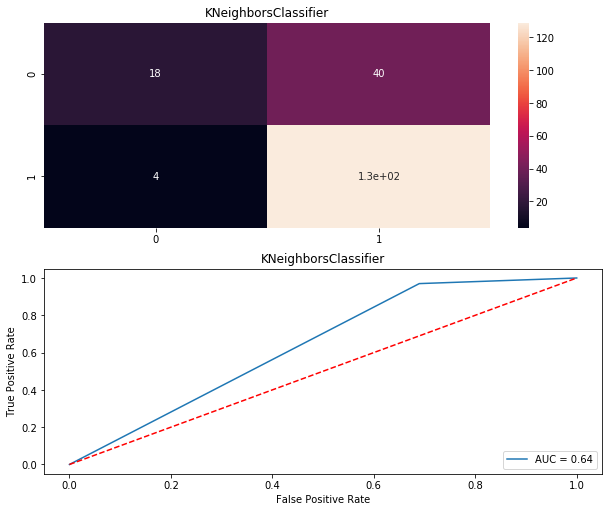

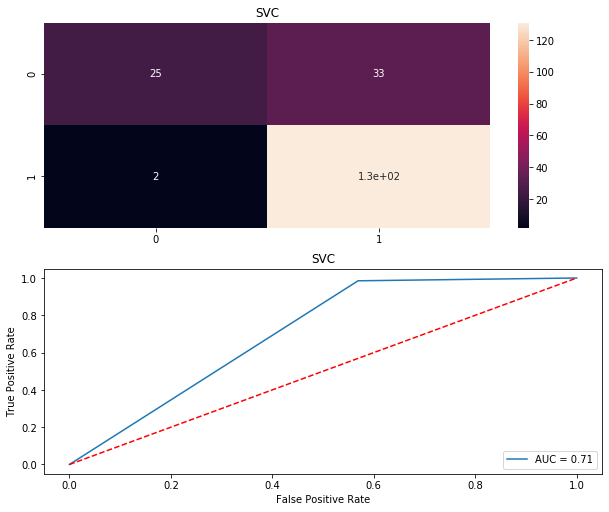

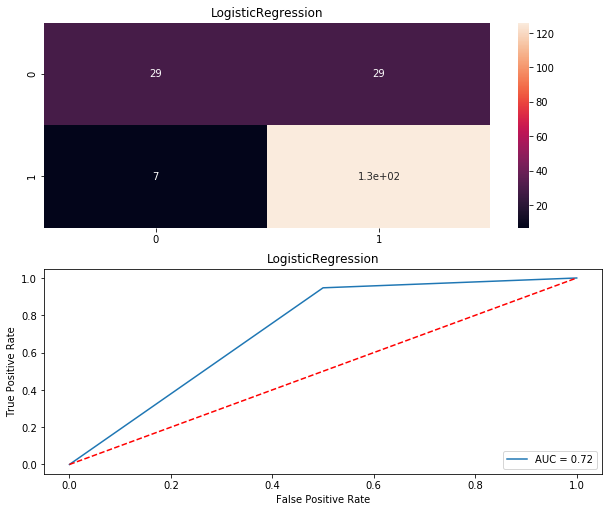

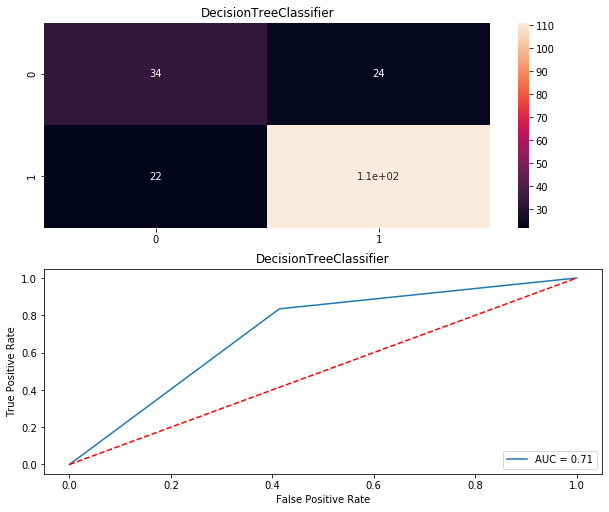

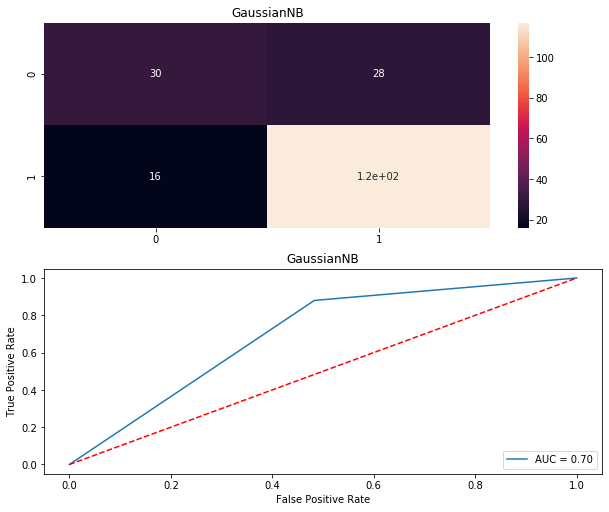

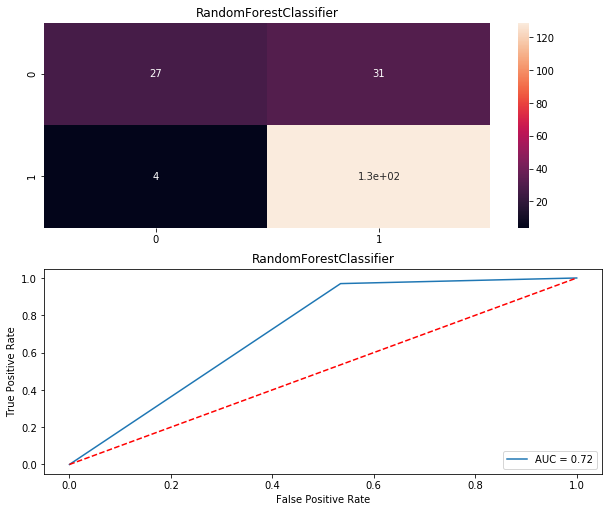

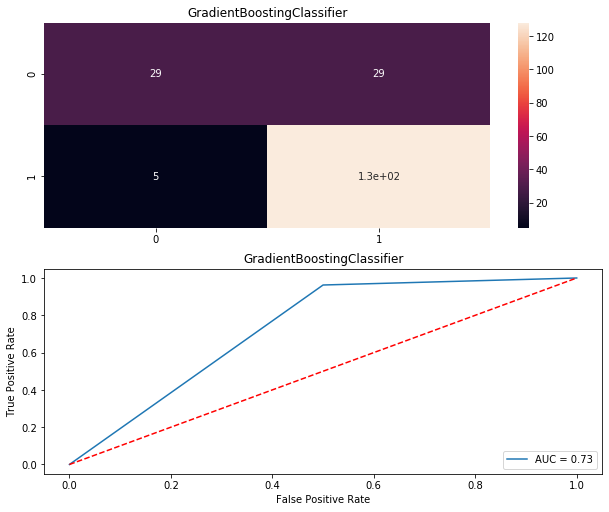

In [54]:
Model = []
score = []
cvs=[]
rocscore=[]
for name,model in models:
    print('***********************',name,'***********************')
    print('\n')
    Model.append(name)
    model.fit(x_train,y_train)
    print(model)
    pre=model.predict(x_test)
    print('\n')
    AS=accuracy_score(y_test,pre)
    print('Accuracy_score = ',AS)
    score.append(AS*100)
    print('\n')
    sc = cross_val_score(model, x, y, cv=10, scoring='accuracy').mean()
    print('Cross_Val_Score = ',sc)
    cvs.append(sc*100)
    print('\n')
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,pre)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print ('roc_auc_score = ',roc_auc)
    rocscore.append(roc_auc*100)
    print('\n')
    print('classification_report\n',classification_report(y_test,pre))
    print('\n')
    cm=confusion_matrix(y_test,pre)
    print(cm)
    print('\n')
    plt.figure(figsize=(10,40))
    plt.subplot(911)
    plt.title(name)
    print(sns.heatmap(cm,annot=True))
    plt.subplot(912)
    plt.title(name)
    plt.plot(false_positive_rate, true_positive_rate, label='AUC = %0.2f'% roc_auc)
    plt.plot([0,1],[0,1],'r--')
    plt.legend(loc='lower right')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    print('\n\n')

In [55]:
result = pd.DataFrame({'Model': Model, 'Accuracy_score': score ,'Cross_val_score':cvs,'Roc_auc_curve':rocscore})
result

,Model,Accuracy_score,Cross_val_score,Roc_auc_curve
0,KNeighborsClassifier,76.963351,79.555354,64.013482
1,SVC,81.675393,81.470054,70.799844
2,LogisticRegression,81.151832,80.604961,72.368421
3,DecisionTreeClassifier,75.916230,66.394434,71.039668
4,GaussianNB,76.963351,77.298851,69.847031
5,RandomForestClassifier,81.675393,75.952813,71.772103
6,GradientBoostingClassifier,82.198953,74.035088,73.120301


In [56]:
from sklearn.externals import joblib

In [61]:
joblib.dump(LR,'loan.pkl')

['loan.pkl']

In [62]:
model=joblib.load('loan.pkl')

In [63]:
model.predict(x_test.head())

array([1, 0, 1, 1, 0], dtype=int8)

In [65]:
x_test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
134,-0.857364,0.477137,-1.362511,-0.809243,-0.541961,-0.38058,0.540502,-1.122446,0.672173,0.142609,0.515236,1.194806
293,0.127355,0.477137,0.733939,1.344671,1.845150,-0.38058,1.185062,-1.122446,0.932028,0.142609,-0.854328,-1.340199
141,-0.811062,-2.095835,-1.362511,-0.809243,-0.541961,-0.38058,1.686615,0.777469,1.487099,0.142609,0.515236,-1.340199
266,-0.022813,0.477137,0.733939,-0.809243,-0.541961,-0.38058,-0.045129,0.537872,-0.330705,0.142609,0.515236,0.015464
118,-0.986600,-2.095835,-1.362511,-0.809243,-0.541961,-0.38058,-1.124091,1.382080,0.150030,0.142609,-2.225007,0.015464


In [66]:
y_test.head()

141    1
309    1
148    0
281    1
122    1
Name: Loan_Status, dtype: int8